<a href="https://colab.research.google.com/github/skitw427/Layerwise-XAI/blob/main/notebook_demo/ResNet18_LRP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install zennit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 4.0 MB/s eta 0:00:00


In [ ]:
import timm
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import ast
import os

In [ ]:
model_name = "resnet18.a1_in1k"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = timm.create_model(model_name, pretrained=True)
model.eval()
model = model.to(device)

cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

In [ ]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

image_dir = 'cat/'

image_tensors = []
for filename in os.listdir(image_dir):
    if filename.endswith('.JPEG'):
        image_path = os.path.join(image_dir, filename)
        image = Image.open(image_path).convert('RGB')
        image_tensor = transform(image)
        image_tensors.append(image_tensor)

if image_tensors:
    input_tensor = torch.stack(image_tensors)
    print(f"Input tensor shape: {input_tensor.shape}")
else:
    print("No JPEG images found in the specified directory.")

input_tensor = input_tensor.to(device)
batch_size = input_tensor.shape[0]

Input tensor shape: torch.Size([8, 3, 224, 224])


In [78]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [73]:
from zennit.composites import EpsilonGammaBox
from zennit.canonizers import SequentialMergeBatchNorm
from zennit.attribution import Gradient

canonizers = [SequentialMergeBatchNorm()]
composite = EpsilonGammaBox(low=-3., high=3., canonizers=canonizers)

target = torch.eye(1000, device=device)[[283]].repeat(batch_size, 1)

with Gradient(model=model, composite=composite) as attributor:
    out, relevance = attributor(input_tensor, target)

In [74]:
import torch.nn.functional as F

# 모델의 출력 `out`에서 softmax를 계산하여 확률 분포로 변환
probs = F.softmax(out, dim=1)

# 각 입력에 대해 top-5 클래스의 인덱스와 확률 계산
top_k = 5
top_probs, top_indices = torch.topk(probs, top_k, dim=1)

# 결과 출력
for i in range(out.size(0)):  # 배치 크기만큼 반복
    print(f"Input {i + 1}:")
    print(out[i][283])
    for k in range(top_k):
        print(f"  Top-{k + 1} Class: {top_indices[i, k].item()}, Probability: {top_probs[i, k].item():.4f}")


Input 1:
tensor(3.4302, device='cuda:0', grad_fn=<SelectBackward0>)
  Top-1 Class: 283, Probability: 0.9764
  Top-2 Class: 760, Probability: 0.0026
  Top-3 Class: 761, Probability: 0.0013
  Top-4 Class: 457, Probability: 0.0008
  Top-5 Class: 478, Probability: 0.0008
Input 2:
tensor(10.6508, device='cuda:0', grad_fn=<SelectBackward0>)
  Top-1 Class: 283, Probability: 1.0000
  Top-2 Class: 287, Probability: 0.0000
  Top-3 Class: 918, Probability: 0.0000
  Top-4 Class: 422, Probability: 0.0000
  Top-5 Class: 722, Probability: 0.0000
Input 3:
tensor(5.8102, device='cuda:0', grad_fn=<SelectBackward0>)
  Top-1 Class: 283, Probability: 0.9989
  Top-2 Class: 287, Probability: 0.0005
  Top-3 Class: 259, Probability: 0.0000
  Top-4 Class: 261, Probability: 0.0000
  Top-5 Class: 332, Probability: 0.0000
Input 4:
tensor(-4.1956, device='cuda:0', grad_fn=<SelectBackward0>)
  Top-1 Class: 281, Probability: 0.2619
  Top-2 Class: 287, Probability: 0.2475
  Top-3 Class: 285, Probability: 0.2343
  Top-

torch.Size([8, 3, 224, 224])
(8, 224, 224)
-0.855868 0.188777
1.1165311e-09 1.0


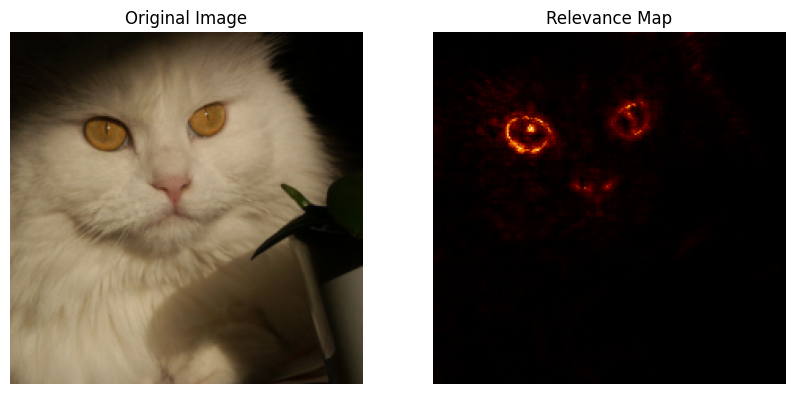

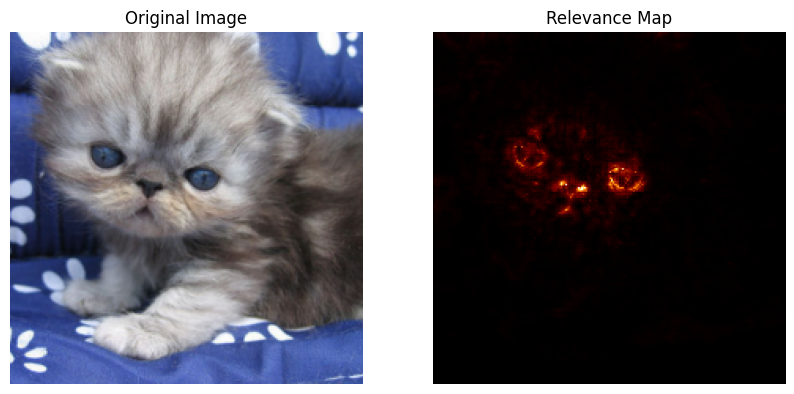

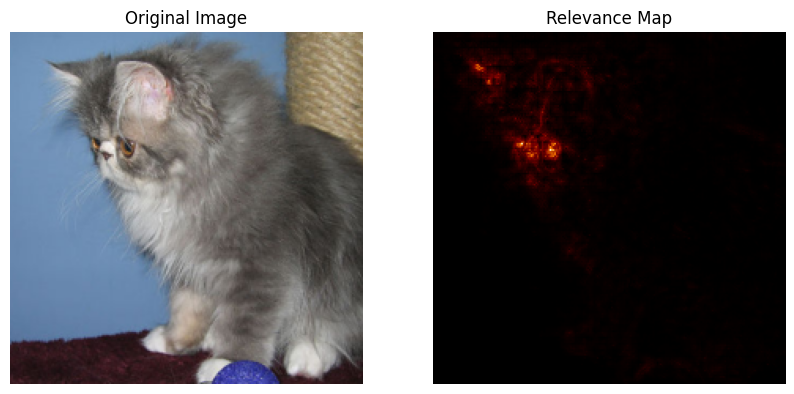

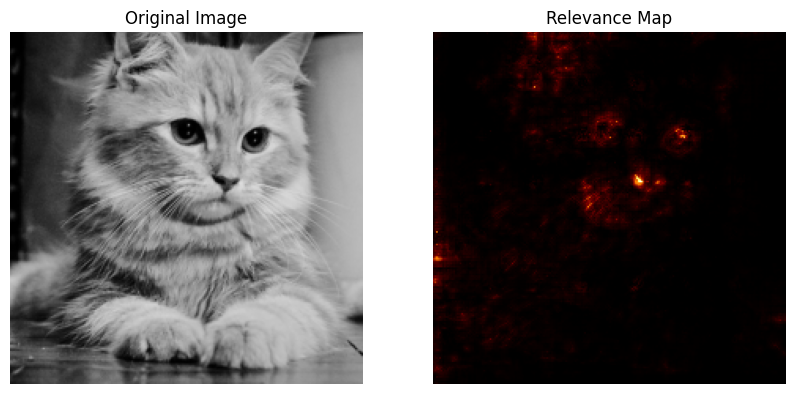

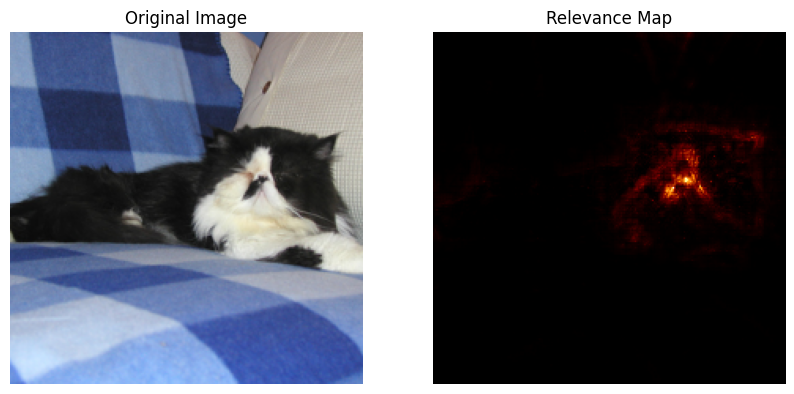

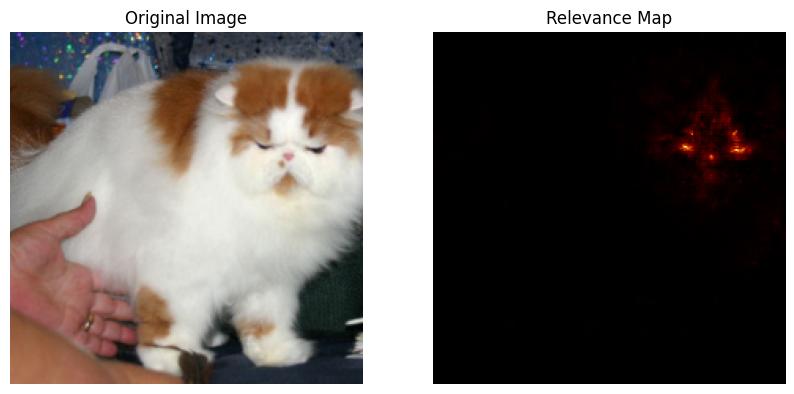

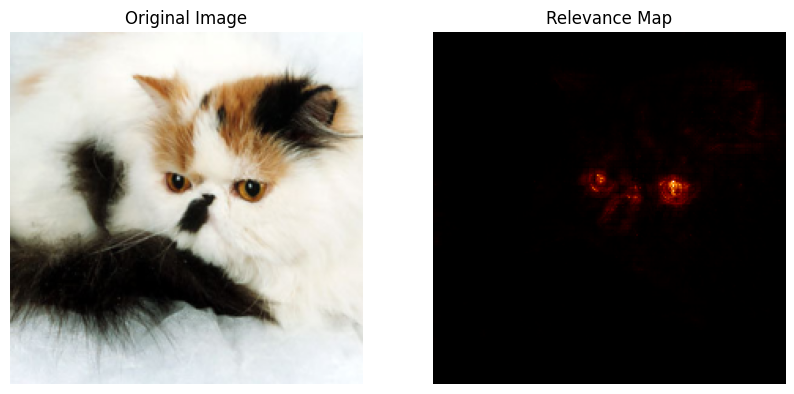

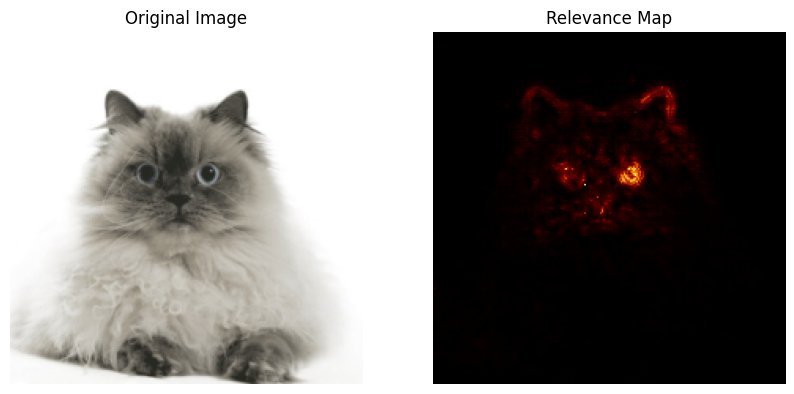

In [77]:
import matplotlib.pyplot as plt

print(relevance.shape)

rel = relevance.sum(1).detach().cpu().numpy()
rgb_img = input_tensor.detach().cpu().numpy().copy()

print(rel.shape)

for b in range(rgb_img.shape[0]):
  for c in range(rgb_img.shape[1]):  # 채널(R/G/B)
    rgb_img[b, c, :, :] = rgb_img[b, c, :, :] * std[c] + mean[c]

img = rgb_img.transpose(0, 2, 3, 1)

print(rel.min(), rel.max())

relevance_norm = 'absolute'
# normalize between 0. and 1. given the specified strategy
if relevance_norm == 'symmetric':
    # 0-aligned symmetric relevance, negative and positive can be compared, the original 0. becomes 0.5
    amax = np.abs(rel).max((1, 2), keepdims=True)
    rel = (rel + amax) / 2 / amax
elif relevance_norm == 'absolute':
    # 0-aligned absolute relevance, only the amplitude of relevance matters, the original 0. becomes 0.
    rel = np.abs(rel)
    rel /= rel.max((1, 2), keepdims=True)
elif relevance_norm == 'unaligned':
    # do not align, the original minimum value becomes 0., the original maximum becomes 1.
    rmin = rel.min((1, 2), keepdims=True)
    rmax = rel.max((1, 2), keepdims=True)
    rel = (rel - rmin) / (rmax - rmin)

print(rel.min(), rel.max())

# 클래스 283의 값을 확인하고 rel 반전 적용
target_class_idx = 283
out_cpu = out.detach().cpu().numpy()

for i in range(batch_size):
    #if out_cpu[i, target_class_idx] < 0:  # 클래스 283 값이 음수일 때
    #    rel[i] = 1 - rel[i]  # 작은 값과 큰 값을 반대로 뒤집음

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(img[i])
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(rel[i], cmap='afmhot', alpha=1)
    plt.title("Relevance Map")
    plt.axis('off')
    plt.show()

torch.Size([8, 3, 224, 224])
(8, 224, 224)
-0.855868 0.188777
Positive relevance range: 0.0 0.99999994
Negative relevance range: 0.0 1.0


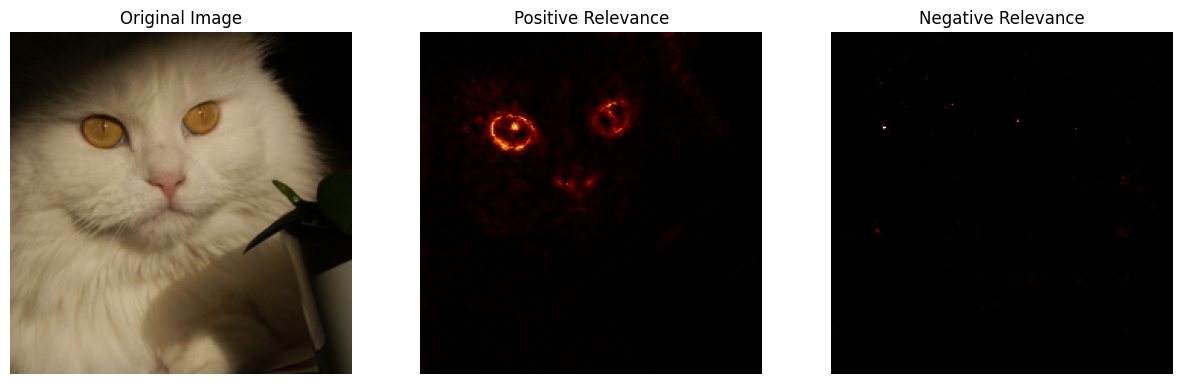

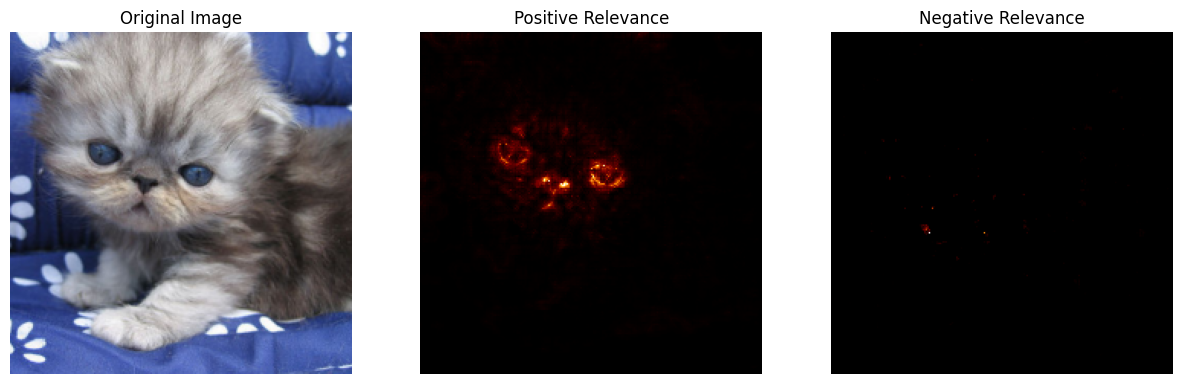

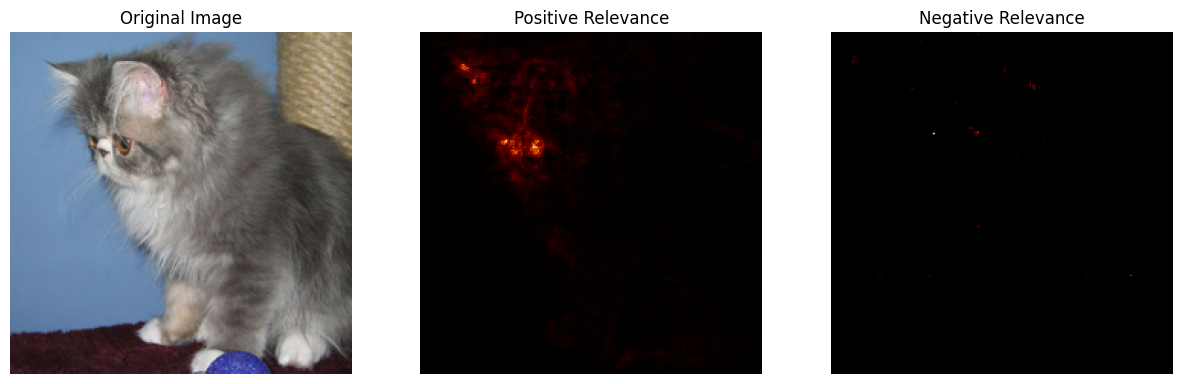

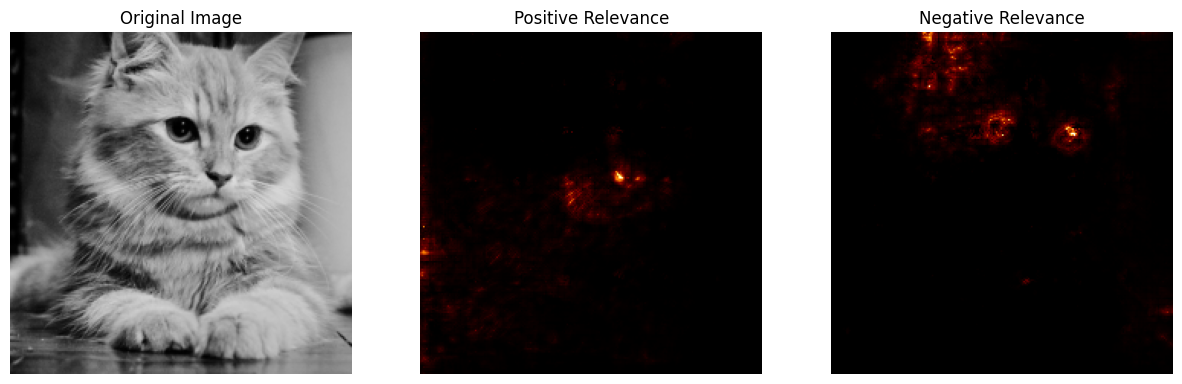

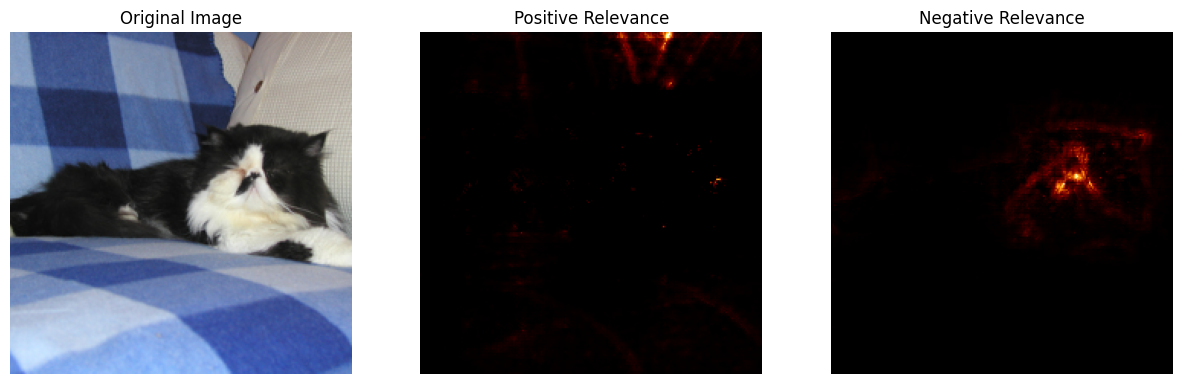

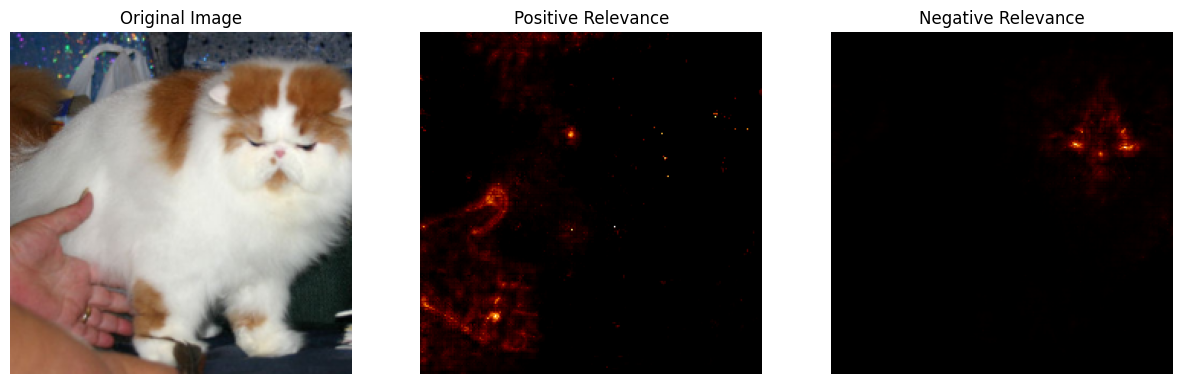

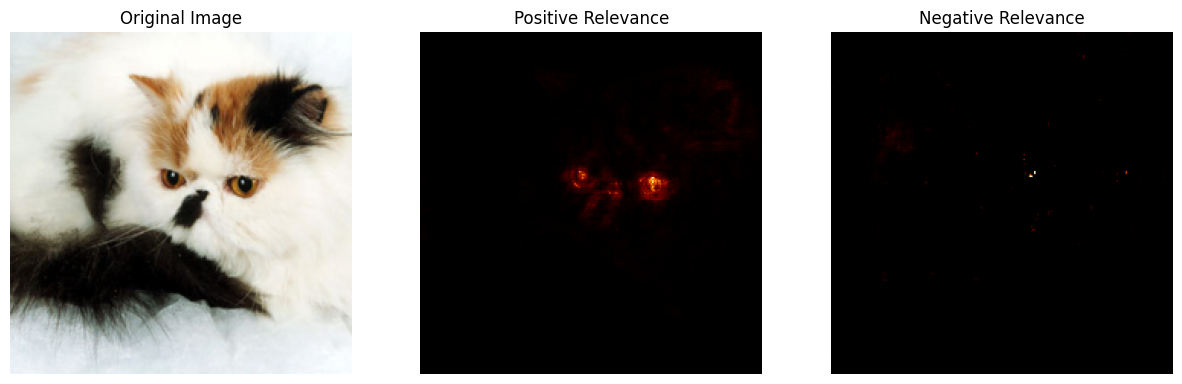

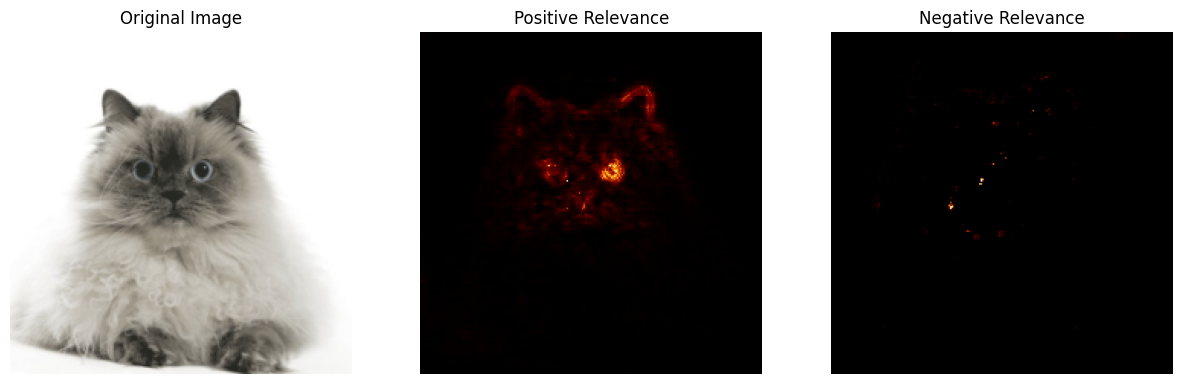

In [76]:
import matplotlib.pyplot as plt
import numpy as np

print(relevance.shape)

rel = relevance.sum(1).detach().cpu().numpy()
rgb_img = input_tensor.detach().cpu().numpy().copy()

print(rel.shape)

# 역정규화하여 원본 이미지를 복원
for b in range(rgb_img.shape[0]):
    for c in range(rgb_img.shape[1]):  # 채널(R/G/B)
        rgb_img[b, c, :, :] = rgb_img[b, c, :, :] * std[c] + mean[c]

img = rgb_img.transpose(0, 2, 3, 1)

print(rel.min(), rel.max())

# 음수와 양수 값을 분리하여 각각 정규화
def normalize(data):
    data_min = data.min((1, 2), keepdims=True)
    data_max = data.max((1, 2), keepdims=True)
    return (data - data_min) / (data_max - data_min + 1e-8)  # 작은 값을 더해 나눗셈 방지

rel_pos = np.maximum(rel, 0)  # 양수 값만 추출
rel_neg = np.minimum(rel, 0)  # 음수 값만 추출
rel_neg = -rel_neg  # 음수 값을 양수로 변환

rel_pos = normalize(rel_pos)
rel_neg = normalize(rel_neg)

print("Positive relevance range:", rel_pos.min(), rel_pos.max())
print("Negative relevance range:", rel_neg.min(), rel_neg.max())

# 클래스 283의 값을 확인하고 rel 반전 적용
target_class_idx = 283
out_cpu = out.detach().cpu().numpy()

for i in range(batch_size):
    plt.figure(figsize=(15, 5))

    # 원본 이미지
    plt.subplot(1, 3, 1)
    plt.imshow(img[i])
    plt.title("Original Image")
    plt.axis('off')

    # 양수 relevance map
    plt.subplot(1, 3, 2)
    plt.imshow(rel_pos[i], cmap='afmhot', alpha=1)
    plt.title("Positive Relevance")
    plt.axis('off')

    # 음수 relevance map
    plt.subplot(1, 3, 3)
    plt.imshow(rel_neg[i], cmap='afmhot', alpha=1)
    plt.title("Negative Relevance")
    plt.axis('off')

    plt.show()


torch.Size([8, 3, 224, 224])
(8, 224, 224)


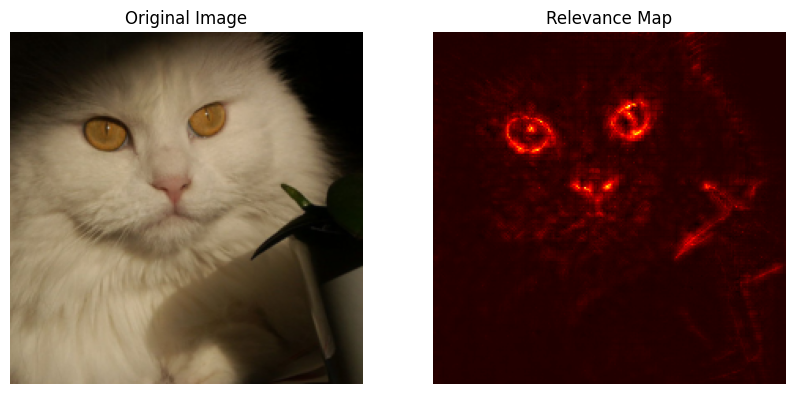

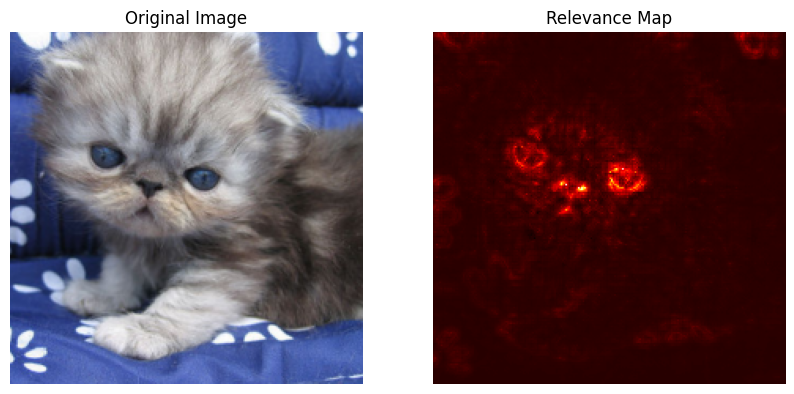

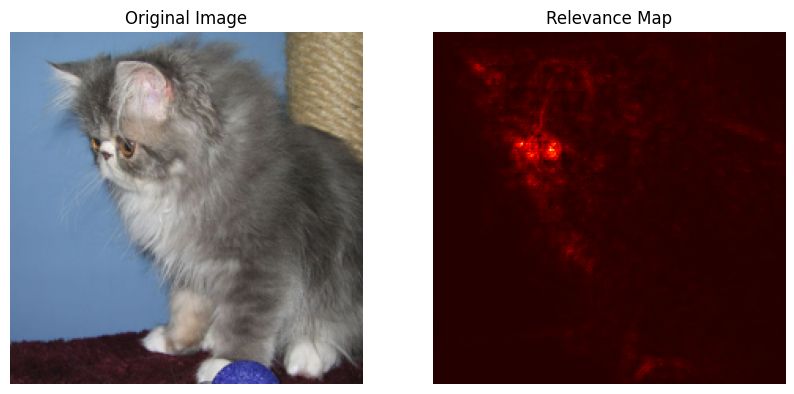

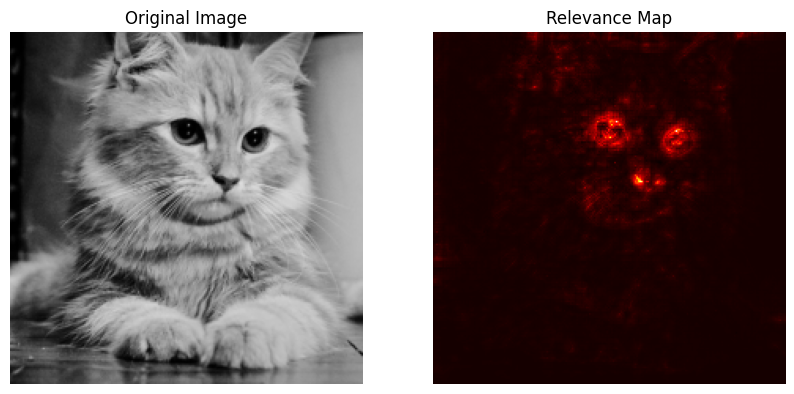

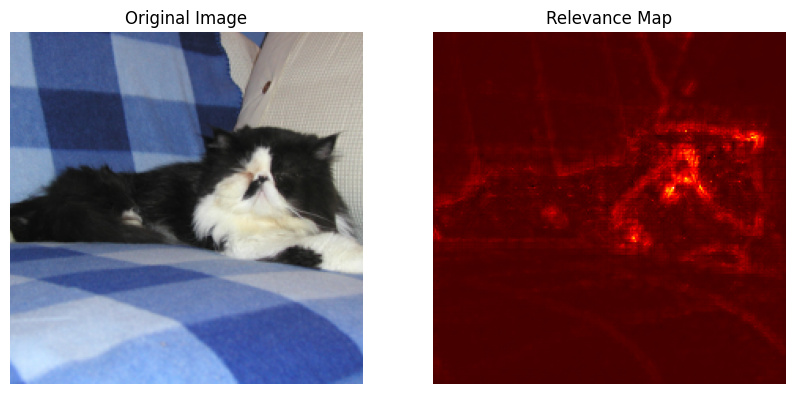

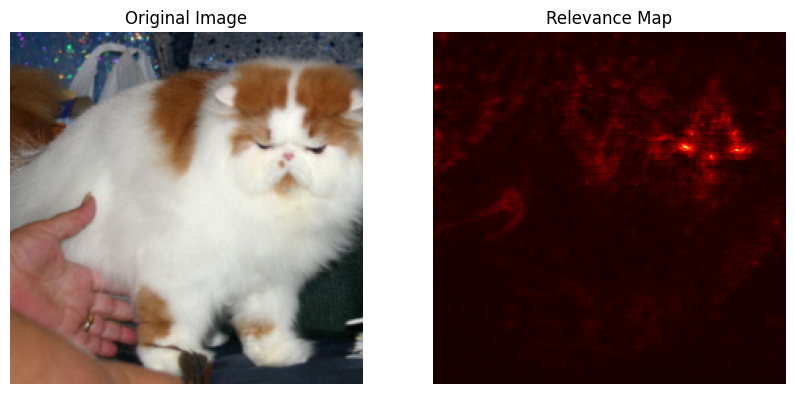

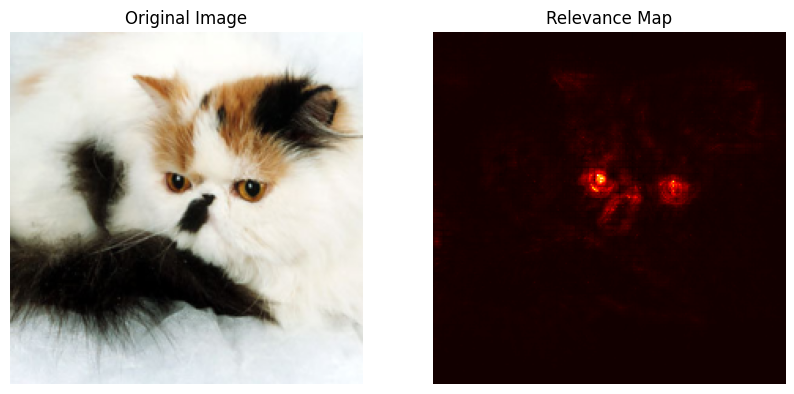

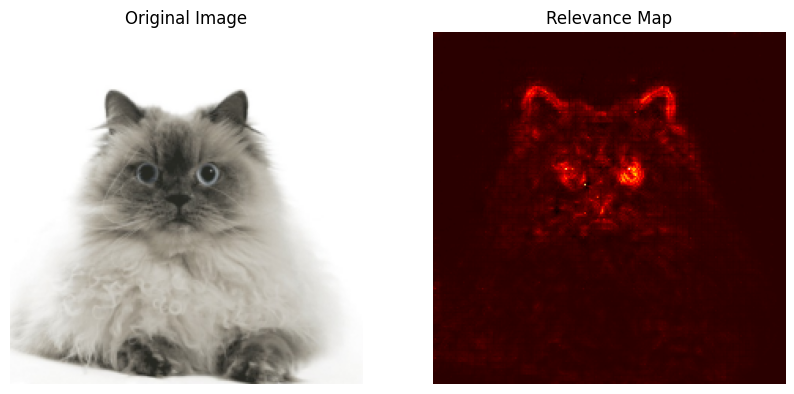

In [52]:
import matplotlib.pyplot as plt

print(relevance.shape)

rel = relevance.sum(1).detach().cpu().numpy()
rgb_img = input_tensor.detach().cpu().numpy().copy()

print(rel.shape)

for b in range(rgb_img.shape[0]):
  for c in range(rgb_img.shape[1]):  # 채널(R/G/B)
    rgb_img[b, c, :, :] = rgb_img[b, c, :, :] * std[c] + mean[c]

img = rgb_img.transpose(0, 2, 3, 1)

relevance_norm = 'symmetric'
# normalize between 0. and 1. given the specified strategy
if relevance_norm == 'symmetric':
    # 0-aligned symmetric relevance, negative and positive can be compared, the original 0. becomes 0.5
    amax = np.abs(rel).max((1, 2), keepdims=True)
    rel = (rel + amax) / 2 / amax
elif relevance_norm == 'absolute':
    # 0-aligned absolute relevance, only the amplitude of relevance matters, the original 0. becomes 0.
    rel = np.abs(rel)
    rel /= rel.max((1, 2), keepdims=True)
elif relevance_norm == 'unaligned':
    # do not align, the original minimum value becomes 0., the original maximum becomes 1.
    rmin = rel.min((1, 2), keepdims=True)
    rmax = rel.max((1, 2), keepdims=True)
    rel = (rel - rmin) / (rmax - rmin)

for i in range(batch_size):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(img[i])
    plt.title("Original Image")

    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(rel[i], cmap='hot', alpha=1)
    plt.title("Relevance Map")
    plt.axis('off')
    plt.show()